In [30]:
%matplotlib inline
import LFPy
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [31]:
# Define cell parameters
cell_parameters = {          # various cell parameters,
    'morphology' : 'morphologies/L5_Mainen96_LFPy.hoc', # Mainen&Sejnowski, 1996
    'cm' : 1.0,         # membrane capacitance
    'Ra' : 150.,        # axial resistance
    'v_init' : -65.,    # initial crossmembrane potential
    'passive' : True,   # turn on passive mechanism for all sections
    'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65}, # passive params
    'nsegs_method' : 'lambda_f', # lambda_f method
    'lambda_f' : 100.,  # lambda_f critical frequency
    'dt' : 2.**-3,      # simulation time step size
    'tstart' : 0.,      # start time of simulation, recorders start at t=0
    'tstop' : 100.,     # stop simulation at 200 ms. These can be overridden
                        # by setting these arguments in cell.simulation()
}

# Create cell
cell = LFPy.Cell(**cell_parameters)

In [32]:
# Define synapse parameters
synapse_parameters = {
    'idx' : cell.get_closest_idx(x=0., y=0., z=200.),
    'e' : 0.,                   # reversal potential
    'syntype' : 'Exp2Syn',       # synapse type
    'tau1' : 0.5,
    'tau2' : 2.,
    'weight' : 0.005,            # syn. weight
    'record_current' : True,
}

#synapse_parameters = {
#    'idx' : cell.get_closest_idx(x=0., y=0., z=900.),
#    'e' : 0.,                   # reversal potential
#    'syntype' : 'ExpSyn',       # synapse type
#    'tau' : 10.,                # syn. time constant
#    'weight' : .001,            # syn. weight
#    'record_current' : True,
#}

# Create synapse and set time of synaptic input
synapse = LFPy.Synapse(cell, **synapse_parameters)

synapse.set_spike_times(np.array([10., 30., 50., 70.]))
#synapse.set_spike_times_w_netstim(noise=1.0, start=0.0, number=1000.0, interval=10.0, seed=1234.0)

In [33]:
# Create a grid of measurement locations, in (mum)
#X, Z = np.mgrid[-500:501:20, -400:1201:40]
#Y = np.zeros(X.shape)
X, Y, Z = np.mgrid[-500:501:50, -500:501:50, -400:1201:50]   #51*51*41
#X, Y, Z = np.mgrid[-500:501:20, -500:501:20, -400:1201:40]   #51*51*41

# Define electrode parameters
electrode_parameters = {
    'sigma' : 0.3,      # extracellular conductivity
    'x' : X.flatten(),  # electrode requires 1d vector of positions
    'y' : Y.flatten(),
    'z' : Z.flatten()
}

# Create electrode object
electrode = LFPy.RecExtElectrode(**electrode_parameters)

In [34]:
# Run simulation, electrode object argument in cell.simulate
cell.simulate(electrode=electrode, rec_imem=True)

[-500, 500, -400, 1200]

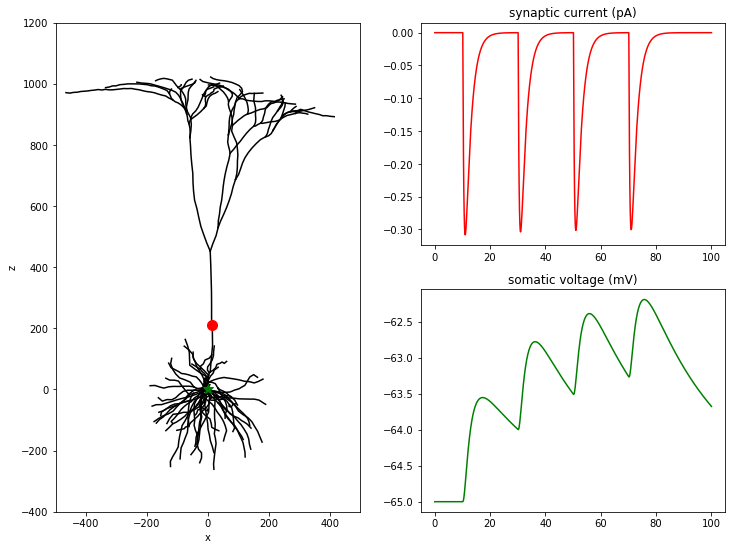

In [35]:
plt.figure(figsize=(12, 9))
plt.subplot(222)
plt.plot(cell.tvec, synapse.i, 'r'), plt.title('synaptic current (pA)')
plt.subplot(224)
plt.plot(cell.tvec, cell.somav, 'g'), plt.title('somatic voltage (mV)')
plt.subplot(121)
for sec in LFPy.cell.neuron.h.allsec():
    idx = cell.get_idx(sec.name())
    plt.plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]], np.r_[cell.zstart[idx], cell.zend[idx][-1]], color='k')

plt.xlabel('x')
plt.ylabel('z')

plt.plot([cell.synapses[0].x], [cell.synapses[0].z], color='r', marker='o', markersize=10)
plt.plot(0.0, 0.0, color='g', marker='*', markersize=10)

plt.axis([-500, 500, -400, 1200])

In [36]:
electrode.calc_lfp()

In [37]:
#print(X.shape, electrode.LFP.shape)

t3= X.shape + (electrode.LFP.shape[-1],)
#print(electrode.LFP.reshape(t3).shape)

#sio.savemat('single_synapse.mat', {'x': X.flatten(),'y': Y.flatten(),'z': Z.flatten(),'lfp':electrode.LFP[:,0]})
sio.savemat('single_synapse.mat', {'lfp':electrode.LFP.reshape(t3)})

In [38]:
lfp_data2 = sio.loadmat('single_synapse.mat')
print(lfp_data2.keys())
print(lfp_data2['lfp'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'lfp'])
(21, 21, 33, 801)


In [39]:
import plotly.graph_objects as go


limLFP = abs(electrode.LFP).max()

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value= electrode.LFP[:,200],
    isomin=np.amin(electrode.LFP[:,200]),
    isomax=np.amax(electrode.LFP[:,200]),
    showscale=False,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.update_layout(scene_xaxis_showticklabels=False,
                  scene_yaxis_showticklabels=False,
                  scene_zaxis_showticklabels=False)
fig.show()


## Plot simulation output:

TypeError: Input z must be a 2D array.

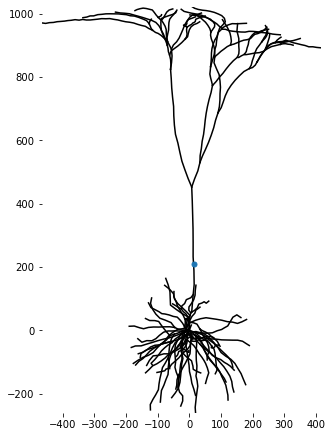

In [40]:
from example_suppl import plot_ex1
fig = plot_ex1(cell, electrode, X, Y, Z, 10)
# Optionally save figure (uncomment the line below)
#fig.savefig('LFPy-example-5.png', dpi=300)
#for i in list(range(1,100)):
    #print('{:0>4}'.format(str(i)))
#    fig = plot_ex1(cell, electrode, X, Y, Z, i)
#    fig.savefig('output/'+'{:0>4}'.format(str(i))+'.png', dpi=300)